<a href="https://colab.research.google.com/github/engogola/Natural-language-processing-NLP-Zero-to--Hero/blob/main/NLP_zero_hero_ogola_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a continuation of the NLP zero to hero ogola learning series

We are going to finish up on the remaining 4 subtopics i.e

1.  word_embeddings

1.  RNNs_LMs

1. Machine_translation_Attention

4. Transformers



**7)WORD EMBEDDINGS**

So far we've seen how to vectorize documents of text either through Bag-of-Words or TF-IDF. While these approaches work well for simple NLP tasks like classification, they have the drawback that they don't capture any relationships between words.

In this notebook, we will see how to vectorize individual words via static embeddings in order to capture word meaning. For example, this will let us model that "brother" and "sister" are more similar in meaning than "tree" and "car". Note that in a later notebook we will also cover contextual embeddings where the embedding can change depending on the context.

The simplest way to vectorize a set of words, is to use one-hot encoding. This maps each word into a vector with length equal to the size of the vocabulary. The vector is completely filled with 0's except for a single entry, which has a 1 correspoding to the index of the word in the vocabulary.


This is a pretty terrible way to vectorize words, not only because it is very memory inefficient but also because there is no relationship between words.

In particular, if the voculary contains 10,000 words, then each vector has length equal to 10,000. Furthermore, any two distinct vectors will always have a dot product equal to 0, corresponding to no similarity.

A better way then would be to represent words as shorter and denser vectors that capture some meaning between words. And this is what an embedding aim to do.

An embedding is simply a representation of an object (e.g. a word, movie, graph, etc) as a vector of real numbers. It embeds an object into a high-dimensional vector space.

Word2vec is a way of learning word embeddings by training shallow neural networks on either the continuous bag-of-words or the skip-gram task. We will discuss both of these shortly. The dimension of the resulting dense vectors is usually between 50-1000 and a common value is 300.


The amazing thing to come out of Word2vec is not only that similar words are close together, but that we can perform addition and subtraction on these word vectors. For example, “king” - “man” + “woman” = "queen". That is, if we take the vectors for king, man, woman and add/subtract them in this way, we will end up with a vector close to the one corresponding to queen. This means that these vectors can capture very precisely abstract concepts (like gender and royalty) without any input from us.

Note that the values in each vector don't necessarily correspond to anything like fantasy, strategy, etc like in the video game example from before. The algorithm learns the best representation even if the numbers don't correspond to anything tangible. The most important thing though is that similar words are close together.



Word2vec is a collection of two algorithms that each learn word vectors indirectly through a word prediction task. One option is Continuous Bag-of-Words (CBOW) and the other is skip-gram.

Training accurate word embeddings from scratch takes a lot of computational resources. If we want to use word vectors in our models then we have a few options depending on the requirements of our task.

Use pre-trained word vectors as model inputs and keep them constant during training.
Use pre-trained word vectors as model inputs and allow the model to tune them during training.
Train word embeddings from scratch at the same time as training the model.
Option 1 will be the fastest and will usually lead to very good results. Option 2 can produce marginally better results if you are willing to take longer to train your model. Option 3 can be useful if you have lots of training data and want to train a model for a very specific task that pretrained embeddings don't perform well on. We will explore these different options with code in the next section.

**Word vector**

We're going to be using pre-trained word vectors via the Gensim library, which we came across last time. These particular vectors are known as the Google News vectors as they were trained on a 3 billion word Google News corpus in 2015. In total, there are 3 million, 300-dimension vectors.

GoogleNews-vectors-negative300 -

Spotify App Reviews -

In [ ]:
!wget "https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300"
!wget"https://"

--2024-09-03 13:40:36--  https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘googlenewsvectorsnegative300.2’

googlenewsvectorsne     [ <=>                ]   9.47K  --.-KB/s    in 0.03s   

2024-09-03 13:40:36 (287 KB/s) - ‘googlenewsvectorsnegative300.2’ saved [9701]

/bin/bash: line 1: wgethttps://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022: No such file or directory


In [ ]:
!wget -O /content/googlenewsvectorsnegative300.bin.gz "https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300"

--2024-09-03 13:58:36--  https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/googlenewsvectorsnegative300.bin.gz’

/content/googlenews     [ <=>                ]   9.53K  --.-KB/s    in 0.03s   

2024-09-03 13:58:37 (300 KB/s) - ‘/content/googlenewsvectorsnegative300.bin.gz’ saved [9761]



In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
import collections
import re
import emoji

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gensim

load word vectors using the gensim library

In [ ]:
!ls -l /content/ # List files in the directory to check if the file exists
!file /content/googlenewsvectorsnegative300.bin.gz # Check the file type
!head -c 10 /content/googlenewsvectorsnegative300.bin.gz # Print first 10 bytes of the file

total 16
-rw-r--r-- 1 root root 9761 Sep  3 13:58 googlenewsvectorsnegative300.bin.gz
drwxr-xr-x 1 root root 4096 Aug 29 13:22 sample_data
/content/googlenewsvectorsnegative300.bin.gz: HTML document, ASCII text, with very long lines (2452), with CRLF line terminators


<!DOCT

In [ ]:
%%time

# Path to dataset
word2vec_path = "/content/googlenewsvectorsnegative300.bin."

# Load 200,000 most common words
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=2000)

ValueError: not enough values to unpack (expected 2, got 0)

We can retrieve a single word vector by passing the token as the key.

In [ ]:
# Get word vector
science = word2vec_model['science']

# Print shape and vector
print('Vector dimension:', science.shape)
print(science)

And we can measure the similarity between any two words by using the .similarity method.

In [ ]:
print(word2vec_model.similarity('science', 'mathematics'))
print(word2vec_model.similarity('science', 'space'))
print(word2vec_model.similarity('science', 'beard'))

We can measure the similarity between sentences by using the .n_similarity method. This expects a list of words and works by averaging the word vectors in each sentence and computing the cosine similarity between the resulting two vectors. This doesn't take word order into account but works quite well.

In [ ]:
word2vec_model.n_similarity("Man goes running".split(),"Woman goes swimming".split())

We can visualize the word vectors in 2 dimensions by using PCA, which is dimensionality reduction technique. This finds the subspace that maximizes the variance of the data, in other words it finds the 2-D plane where the data points are as spread out as possible. This allows us to get a better idea of the structure and patterns in the word vectors.

In [ ]:
# Vectors to transform
words = ["football","tennis","rugby","river","ocean","water","brownie","jelly","cake"] #['swim', 'swimming', 'cat', 'dog', 'feline', 'road', 'car', 'bus']
word_vectors = np.array([word2vec_model[w] for w in words])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(word_vectors)

# Plot transformed vectors
plt.figure(figsize=(12,6))
plt.scatter(X_pca[:,0], X_pca[:,1], edgecolors='k', c='g', s=128)
for word, (x,y) in zip(words, X_pca):
    plt.text(x+0.01,y+0.01, word)
plt.title("PCA plot of word vectors", y=1.02)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Modelling with pretrained word Embeddings.

To showcase how word embeddings can be used in neural networks, we are going to perform sentiment analysis on a spotify app reviews dataset. Each review has a corresponding number of stars awarded between 1 and 5, which is what we are going to try to predict.

In [ ]:
!unzip /content/archive (3).zip
data = pd.read_csv('/content/archive (3).zip')
data =data[["Review","Rating"]]

#print shape and preview
print(data.shape)
data.head()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `unzip /content/archive (3).zip'
(61594, 2)


,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1


Currently some of the reviews are very long (the maximum is over 3000 characters!). Later in our keras model we will truncate these so they are not longer than 250 characters, which will speed up training time.

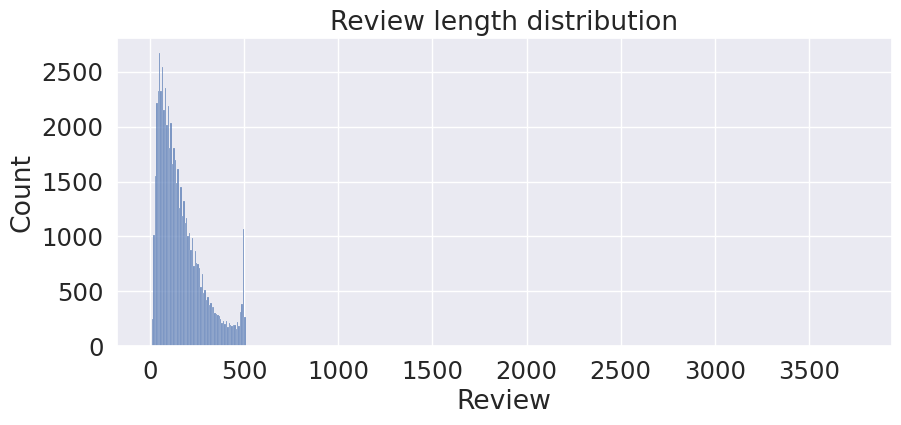

In [ ]:
#length of reviews
plt.figure(figsize=(10,4))
sns.histplot(data['Review'].apply(lambda x : len(x)))
plt.title("Review length distribution")
plt.show()

We got to do some data cleaning

In [ ]:
#cleaning text function
def clean_text(text):
    text = emoji.demojize(text)   #remove emojis
    text = text.replace("_", " ") #remove underscores
    text = re.sub(r'http\S+', '', text) #remove urls
    text = text.strip()            #remove extra spaces
    return text

    #applying cleaning function
    data['Review'] = data['Review'].apply(lambda x : clean_text(x))

Features and labels

In [ ]:
#Define features and labels
X = data['Review']
y = data['Rating'] - 1   # map ti 0,1,2,3,4

Train-Valid-test split

In [ ]:
# Create train, validation and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.25, shuffle=True, stratify=y_tr, random_state=0) # 0.25 * 0.8 = 0.2

# Print shapes
print("Train size:", X_train.shape)
print("Valid size:", X_valid.shape)
print("Test size:", X_test.shape)

Train size: (36956,)
Valid size: (12319,)
Test size: (12319,)


Tokenizer


Instead of using spacy, this time we will create a tokenizer using keras because it will more easily integrate with our keras model. We set it to remove special characters, lower case all words and only use the most frequent 20000 words. This allows the model to focus only on the most frequent words that are relevant to the sentiment and speeds up training time.

In [ ]:
# Keras tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000, filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Build vocabulary on train set
tokenizer.fit_on_texts(X_train)

Vectorize

We are going to vectorize by mapping every token to an integer ID that we can use to look up word vectors.



In [ ]:
# Vectorize
X_train_ids = tokenizer.texts_to_sequences(X_train)
X_valid_ids = tokenizer.texts_to_sequences(X_valid)
X_test_ids = tokenizer.texts_to_sequences(X_test)

# Example
print(X_train_ids[0][:10])

[1, 115, 8, 29, 28, 930, 24, 10, 206, 22]


Padding is a common technique used to convert all the sequences to the same length. Longer sequences are truncated and shorter sequences are padded with 0's at the beginning. This is required for some models (not here) but it can also make it easier to optimize the loss function.

In [ ]:
# Max length of sequences
max_length = 250

# Pad sequences
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_ids, maxlen=max_length)
X_valid_pad = keras.preprocessing.sequence.pad_sequences(X_valid_ids, maxlen=max_length)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_ids, maxlen=max_length)

# Example
print(X_train_pad[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   1 115   8  29  28 930  24
  10 206  22   5 260  71 183  22   8  26 108  88  28 930 221   5   5  97
 268 183  22  45 930 288  30  78  39 202  40  73   

We now to map the word ids to the word vectors in gensim so we can use them in our model. We do this by creating an embedding matrix that stores the word vectors in the right order if they exist (otherwise fill that row with 0's).

In [ ]:
# Load 1,000,000 most common words
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1_000_000)

# Add one for padding token
num_tokens = len(tokenizer.word_index) + 1

# Word vector dimension
embedding_dim = 300

# Initialize matrix of zeros
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Fill embedding matrix
for word, i in tokenizer.word_index.items():
    if word2vec_model.has_index_for(word):
        embedding_matrix[i] = word2vec_model[word].copy()

NameError: name 'word2vec_path' is not defined

Build model

We're now ready to build the model. The first layer of the neural network will be an embedding layer with our embedding matrix as input. We'll set trainable = True so the model can fine tune these word vectors. This is a good idea since we found out many of the vectors are 0's.

In [ ]:
# Embedding layer with pre-trained word vectors
embedding_layer = layers.Embedding(
    input_dim = num_tokens,
    output_dim = embedding_dim,
    embeddings_initializer = keras.initializers.Constant(embedding_matrix),
    input_length = max_length,
    trainable = True
)

NameError: name 'num_tokens' is not defined

In [ ]:
# Build model
def build_model(embedding_layer):
    model = keras.Sequential([

        # Look up word vectors from integer ids
        embedding_layer,

        # Average all word vectors in sequence
        layers.GlobalAveragePooling1D(),

        # Fully connected layers
        layers.Dense(units=256, activation='relu', kernel_initializer=tf.keras.initializers.random_normal()),
        layers.Dense(units=128, activation='relu', kernel_initializer=tf.keras.initializers.random_normal()),

        # Output layer (softmax returns a probability distribution)
        layers.Dense(units=5, activation='softmax', kernel_initializer=tf.keras.initializers.random_normal())
    ])

    # Define optimizer, loss function and accuracy metric
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

the model parameters come from embedding layer

In [ ]:
# Build model
model = build_model(embedding_layer)

# Model summary
model.summary()

Train Model

In [ ]:
# Train model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=10,
    batch_size=128,
    verbose=True

Learning curves


It is clear that the model begins to overfit very quickly because of the large number of trainable parameters in our model. If we set trainable = False then we would see less overfitting, although the accuracy wouldn't necessarily improve by much. In future notebooks, we will explore how to reach better performance with sequential neural networks.

In [ ]:
# Plot learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

print('Final accuracy on validation set:', history_df.loc[len(history_df)-1,'val_sparse_categorical_accuracy'])

Evaluate on test set

In [ ]:
# Plot learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

print('Final accuracy on validation set:', history_df.loc[len(history_df)-1,'val_sparse_categorical_accuracy'])

Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, class_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

7)RNNs_LMs

We're going to build a bidirectional LSTM to perform Part-of-Speech (PoS) tagging. We'll use datasets from nltk to train our model.

Shakespear Text(https://www.kaggle.com/datasets/adarshpathak/shakespeare-text)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import requests
import nltk
from nltk.corpus import treebank, brown, conll2000
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Load data


We'll use 3 PoS datasets together. Because they all have different tagging schemes, we also download the universal tagging schema to ensure they are all tagged consistently. Note that this simplifies some of the tags, for example example proper noun is converted to noun.

In [ ]:
# PoS datasets
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')

# Use universal tagging system
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
# Retrieve all PoS-tagged sentences and join them in one list
tagged_sentences = treebank.tagged_sents(tagset='universal') + brown.tagged_sents(tagset='universal') + conll2000.tagged_sents(tagset='universal')

# Example
print("Dataset size:", len(tagged_sentences))
print(tagged_sentences[0])

Dataset size: 72202
[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]


separate features and labels

In [ ]:
# Initalize
X, y = [], []

# Split sentences into words and tags
for s in tagged_sentences:
    sentence, tags = zip(*s)
    X.append(list(sentence))
    y.append(list(tags))

# Example
print(X[0])
print(y[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']


Train-Valid-Test split

In [ ]:
# Create train, validation and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.25, shuffle=True, random_state=0) # 0.25 * 0.8 = 0.2

# Print shapes
print("Train size:", len(X_train))
print("Valid size:", len(X_valid))
print("Test size:", len(X_test))

Train size: 43320
Valid size: 14441
Test size: 14441


Tokenizer

We need to tokenize both the features and the labels using two different tokenizers as they are both sequences.

In [ ]:
# Define tokenizers
word_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tag_tokenizer = keras.preprocessing.text.Tokenizer()

# Fit tokenizers
word_tokenizer.fit_on_texts(X_train)
tag_tokenizer.fit_on_texts(y_train)

# Print vocabulary sizes
print("Word vocabulary size:", len(word_tokenizer.word_index))
print("Tag vocabulary size:", len(tag_tokenizer.word_index))

# Print set of tags
print("\nPossible tags:", tag_tokenizer.word_index)

Word vocabulary size: 46881
Tag vocabulary size: 12

Possible tags: {'noun': 1, 'verb': 2, '.': 3, 'adp': 4, 'det': 5, 'adj': 6, 'adv': 7, 'pron': 8, 'conj': 9, 'prt': 10, 'num': 11, 'x': 12}


In [ ]:
# Map tokens to integer ids
X_train_ids = word_tokenizer.texts_to_sequences(X_train)
X_valid_ids = word_tokenizer.texts_to_sequences(X_valid)
X_test_ids = word_tokenizer.texts_to_sequences(X_test)

y_train_ids = tag_tokenizer.texts_to_sequences(y_train)
y_valid_ids = tag_tokenizer.texts_to_sequences(y_valid)
y_test_ids = tag_tokenizer.texts_to_sequences(y_test)

Padding


Padding is a way of making all input sequences the same length, by filling shorter sequences with 0's and truncating longer sequences. Although is isn't necessarily required for RNNs, it usually speeds up training because it is easier to batch training examples together.

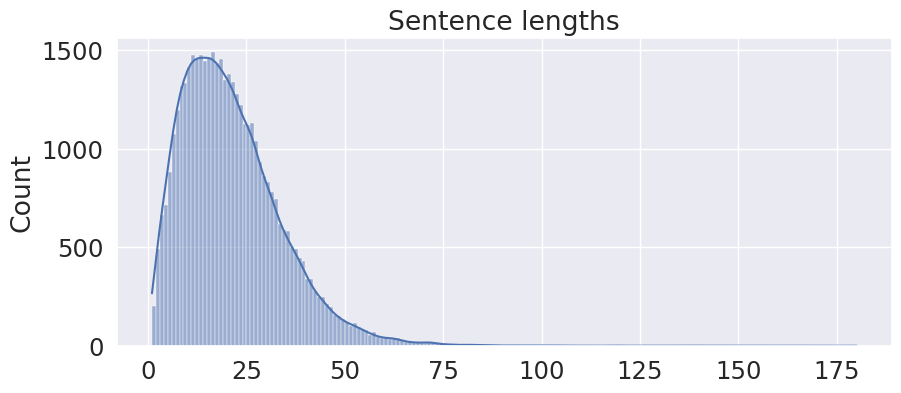

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot([len(X_train_ids[i]) for i in range(len(X_train_ids))], binwidth=1, kde=True)
plt.title('Sentence lengths')
plt.show()

Since most sentences have less than 75 words, we'll truncate longer sentences to only include the first 75 words. A more sophisticated approach would be to truncate on a batch-by-batch basis to reduce the number of unnecessary 0's but this will still work well.

In [ ]:
# Maximum length of sequences
max_length = 75

# Pad sequences
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_ids, padding='post', maxlen=max_length)
X_valid_pad = keras.preprocessing.sequence.pad_sequences(X_valid_ids, padding='post', maxlen=max_length)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_ids, padding='post', maxlen=max_length)

y_train_pad = keras.preprocessing.sequence.pad_sequences(y_train_ids, padding='post', maxlen=max_length)
y_valid_pad = keras.preprocessing.sequence.pad_sequences(y_valid_ids, padding='post', maxlen=max_length)
y_test_pad = keras.preprocessing.sequence.pad_sequences(y_test_ids, padding='post', maxlen=max_length)

# Example
print(X_train_pad[0])

[  10 6746   18 5574  491   25 1237  582    5 5575  393    2  101  375
   27  441 5931  582    3 5574   14 9422  393    8  101  319    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


Build model


Our model will consist of an embedding layer followed by a bidirectional LSTM.

Note that mask_zero = True tells the embedding layer to ignore padding values so the model won't make predictions at these time steps. This will make it easier to properly evaluate our model as we only care about its performance on non-padded values.

Furthermore, since this is a sequence labelling task we want our model to make a prediction at each time step. Setting return_sequences = True accomplishes that.

In [ ]:
# Input/output size (+ 1 for padding token)
num_tokens = len(word_tokenizer.word_index) + 1
num_classes = len(tag_tokenizer.word_index) + 1

# Embedding dimension
embedding_dim = 128

In [ ]:
# Build model
model = keras.Sequential([

    # Map integer ids to trainable word vectors
    layers.Embedding(input_dim = num_tokens,
                           output_dim = embedding_dim,
                           input_length = max_length,
                           mask_zero = True),

    # Bidirectional LSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences = True,
                           kernel_initializer = tf.keras.initializers.random_normal(seed=0))),

    # Output layer
    layers.Dense(num_classes, activation='softmax',
                           kernel_initializer=tf.keras.initializers.random_normal(seed=0))
])

# Define optimizer, loss function and accuracy metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train model


We'll use early stopping to prevent overfitting to the train set.

In [ ]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Train model
history = model.fit(
    X_train_pad, y_train_pad,
    validation_data = (X_valid_pad, y_valid_pad),
    epochs = 20,
    batch_size = 128,
    callbacks = [early_stopping],
    verbose = True
)

Evaluate Model

In [ ]:
# Evaluate model
model.evaluate(X_test_pad, y_test_pad)

452/452 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - loss: 0.1203 - sparse_categorical_accuracy: 0.2694


[0.12069670855998993, 0.26805630326271057]

Tag new samples

In [ ]:
# Tag new sentences
def tag_new_sentences(sentences):
    # Tokenize new sentences
    X_new_ids = word_tokenizer.texts_to_sequences(sentences)

    # Pad sequences
    X_new_pad = keras.preprocessing.sequence.pad_sequences(X_new_ids, padding = 'post', maxlen = max_length)

    # Make predictions
    X_new_preds = model.predict(X_new_pad)

    # Retrieve most likely tag for each word
    sentence_tags = []
    for i, preds in enumerate(X_new_preds):
        # Extract tags for only non-padded tokens
        tags_seq = [np.argmax(p) for p in preds[:len(X_new_ids[i])]]

        # Convert ids back to tokens
        words = [word_tokenizer.index_word[w] for w in X_new_ids[i]]
        tags = [tag_tokenizer.index_word[t] for t in tags_seq]

        # zip words and tags together
        sentence_tags.append(list(zip(words, tags)))

    return sentence_tags

In [ ]:
# Example sentences
ex = [
    "Newly discovered green comet comes close to Earth.",
    "Nasa's Mars rover Perseverance completes rock depot.",
]

# Tag sentences
ex_tagged = tag_new_sentences(ex)

# Print results
print(ex_tagged[0])
print('\n',ex_tagged[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
[('newly', 'adv'), ('discovered', 'verb'), ('green', 'adj'), ('comet', 'noun'), ('comes', 'verb'), ('close', 'adv'), ('to', 'adp'), ('earth', 'noun')]

 [('<OOV>', 'adj'), ('mars', 'noun'), ('rover', 'noun'), ('perseverance', 'noun'), ('completes', 'verb'), ('rock', 'noun'), ('depot', 'noun')]


Language Modelling

We're now going to build a language model to generate text like William Shakespear. To train this model, we'll use a text file that contains the scripts for all of Shakespear's plays.

In [ ]:
# Load text file
!unzip /content/archive\(4\).zip
# Load text file
text = open('/content/content/conll2003.txt', 'r').read() # Changed file name to the extracted file

# Preview text
print(text[:300])

**THE TRANSFORMER**

In this notebook, we are going to go through what a transformer is, build one from scratch and then download a pre-trained model from hugging face and fine-tune it for a text classification problem.

We've already discussed how the inputs are first passed through an embeddding layer and combined with a positional encoding before being going through the first encoder block.

The encoder block is made up of a multi-head attention layer followed by a two layered feed forward neural network applied pointwise. In the paper, the dimensions of the layers were 512 for the input layer, 2048 for the hidden layer and 512 for the output layer. Furthermore, the encoder was made up of 6 encoder blocks stacked on top of each other.

Quickly after the original paper came out, a whole host of different transformers were released. These can be categorized into encoder only (e.g. BERT), decoder only (e.g. GPT) and encoder-decoder (e.g. T5). Let's briefly discuss the main models and see how they are different to each other.

BERT stands for Bidirectional Encoder Representations from Transformers and has up to 340 million parameters. It was trained by a team at Google using masked language modelling, i.e. guess the missing word in a sentence.

DistilBERT is a distilled version of BERT that achives 97% performance of BERT while being 60% faster. It can be used for text classification and sequence labelling tasks.

RoBERTa is similar to BERT but was trained for much longer and with better design choices. It significantly exceeded the performance of BERT on some tasks.

XLM is a cross-lingual language model variant of BERT that smashed several benchmarks on multilingual and translation tasks.

ALBERT is an optimized version of BERT that used fewer parameters thus making it possible to train larger models with fewer parameters.

GPT stands for Generative Pre-trained Transformer and is a family of decoder only transformers developed by OpenAI and used for text generation tasks. These were trained on next word prediction and are able to produce coherent text thanks to its enormous model size (GPT-3 has 175 billion parameters!).

T5 is a high-performing encoder-decoder transformer based on the original paper and is used for sequence-to-sequence tasks.

**Building a transformer from scratch**

To reinforce our understanding of transformers, lets write the code to implement one from scratch. We wont't be able to train it on our own but we will later see how was can use transfer learning to fine tuning a pre-trained transformer for our applications.

Sentiment Analysis Company Reviews -

In [3]:
#import libraries
import numpy as np
import tensorflow as tf


Multi-Head Attention

This implementation of Multi-Head Attention uses the same Q, K, V matrices in each head. It also allows for inputs corresponding to padding to be masked out.

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Head dimension
        self.d_head = self.d_model // self.num_heads

        # Trainable parameters
        self.Wq = tf.keras.layers.Dense(self.d_model)
        self.Wk = tf.keras.layers.Dense(self.d_model)
        self.Wv = tf.keras.layers.Dense(self.d_model)

        # Fully connected layer
        self.dense = tf.keras.layers.Dense(self.d_model)

    # Scaled dot product attention
    def attention(self, query, key, value, mask=None):
        key_dim = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = tf.matmul(query, key, transpose_b=True) / np.sqrt(key_dim)

        if mask is not None:
            scaled_scores = tf.where(mask==0, -np.inf, scaled_scores)

        softmax = tf.keras.layers.Softmax()
        weights = softmax(scaled_scores)
        return tf.matmul(weights, value), weights

    # Reshape and transpose Q, K, V
    def split_heads(self, x):
        batch_size = x.shape[0]

        split_inputs = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_head))
        return tf.transpose(split_inputs, perm=[0, 2, 1, 3])

    # Reverses previous function
    def merge_heads(self, x):
        batch_size = x.shape[0]

        merged_inputs = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(merged_inputs, (batch_size, -1, self.d_model))

    # Forward pass
    def call(self, q, k, v, mask):
        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        output, attention_weights = self.attention(Q, K, V, mask)
        output = self.merge_heads(output)

        return self.dense(output), attention_weights

Encoder block

Like in the original paper, dropout is applied between layers.

In [5]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)

        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        # Layer normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()

    # Feed forward neural network
    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])

    # Forward pass
    def call(self, x, mask):
        mha_output, attention_weights = self.mha(x, x, x, mask)
        mha_output = self.dropout1(mha_output)
        mha_output = self.layernorm1(x + mha_output)

        ffnn_output = self.ffnn(mha_output)
        ffnn_output = self.dropout2(ffnn_output)
        output = self.layernorm2(mha_output + ffnn_output)

        return output, attention_weights

Encoder

Recall that it is more common to use a trainable embedding layer for the positional encoding, which is what we will use here. Note also that the paper applied dropout to the embeddings before the encoder blocks.

In [6]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, src_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.token_embed = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.positional_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        # Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Encoder blocks
        self.blocks = [EncoderBlock(self.d_model, num_heads, hidden_dim, dropout_rate)
                        for _ in range(num_blocks)]

    # Forward pass
    def call(self, inpt, mask):
        token_embeds = self.token_embed(inpt)

        # Position indices for batch of input sequences
        num_pos = inpt.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, inpt.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        # Pass input through decoder blocks
        for block in self.blocks:
            x, weights = block(x, mask)

        return x, weights

Decoder Block

In [7]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

    # Feed forward neural network
    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])

    # Forward pass
    def call(self, encoder_output, target, decoder_mask, memory_mask):
        mha_output1, attention_weights = self.mha1(target, target, target, decoder_mask)
        mha_output1 = self.dropout1(mha_output1)
        mha_output1 = self.layernorm1(mha_output1 + target)

        mha_output2, attention_weights = self.mha2(mha_output1, encoder_output,
                                                encoder_output, memory_mask)
        mha_output2 = self.dropout2(mha_output2)
        mha_output2 = self.layernorm2(mha_output2 + mha_output1)

        ffnn_output = self.ffnn(mha_output2)
        ffnn_output = self.dropout3(ffnn_output)
        output = self.layernorm3(ffnn_output + mha_output2)
        return output, attention_weights

Decoder

In [8]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_embed = tf.keras.layers.Embedding(target_vocab_size, self.d_model)
        self.pos_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.blocks = [DecoderBlock(d_model, num_heads, hidden_dim, dropout_rate) for _ in range(num_blocks)]

    def call(self, encoder_output, target, decoder_mask, memory_mask):
        token_embeds = self.token_embed(target)

        # Position indices for batch of sequences
        num_pos = target.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, target.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        for block in self.blocks:
            x, weights = block(encoder_output, x, decoder_mask, memory_mask)

        return x, weights

Transfomer

Putting the pieces together, we have arrived at the transformer model.

In [9]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, source_vocab_size,
               target_vocab_size, max_input_len, max_target_len, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_blocks, d_model, num_heads, hidden_dim, source_vocab_size,
                               max_input_len, dropout_rate)

        self.decoder = Decoder(num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
                               max_target_len, dropout_rate)

        # Final output layer
        self.output_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input_seqs, target_input_seqs, encoder_mask, decoder_mask, memory_mask):
        encoder_output, encoder_attention_weights = self.encoder(input_seqs, encoder_mask)

        decoder_output, decoder_attention_weights = self.decoder(encoder_output, target_input_seqs,
                                                            decoder_mask, memory_mask)

        return self.output_layer(decoder_output), encoder_attention_weights, decoder_attention_weights

**FINE-TUNING**

Training a transformer from scratch requires lots of data and compute, which can be expensive. Luckily, we can use transfer learning to leverage pre-trained transformer models and fine-tune these for our specific application.

The idea is to add a new classification head on top of a pre-trained model and then train the entire model whilst using a different learning rate for each layer. In general, the closer the layer is to the input sequence the smaller the learning rate will be.

Let's see how to do this using the Hugging Face ecosystem, which is a company that aims to make machine learning accessible to everyone. In particular, we will download a pre-trained DistilBERT model and fine-tune this on a sentiment analysis task.

In [1]:
!pip install datasets
!pip install transformers

In [2]:

!pip uninstall -y pyarrow
!pip install pyarrow --no-cache-dir

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Successfully uninstalled pyarrow-17.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 189.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import datasets
from datasets import load_dataset

Load Data

In [4]:
!unzip /content/sentiment-analysis-company-reviews.zip

Archive:  /content/sentiment-analysis-company-reviews.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
#load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')

#preview data
print(train.shape)
train.head()

(60000, 3)


,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


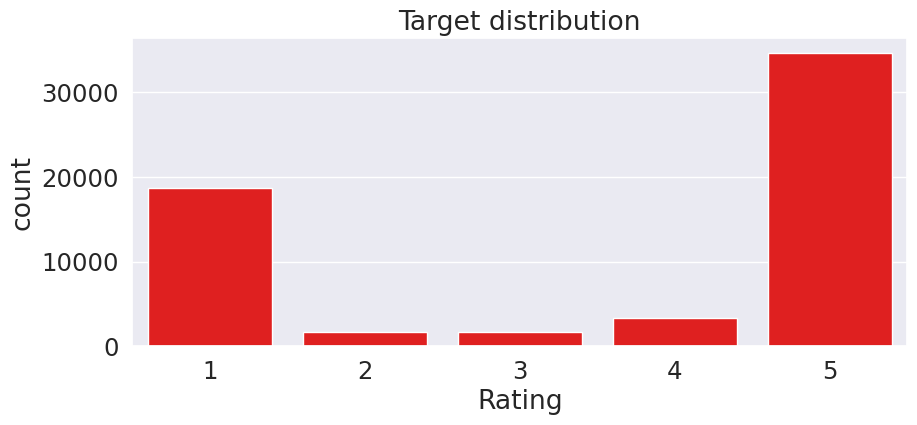

In [11]:
# Explore target distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train,color='red', x="Rating")
plt.title("Target distribution")
plt.show()

Pre-process data


We have to make some small changes to our dataset so it is compatible with the Hugging Face dataset object.

In [12]:
# Map labels
train["Rating"] = train["Rating"] - 1

# Create validation set
X_train, X_valid, _, _ = train_test_split(train, train["Rating"], test_size=0.2, shuffle=True, random_state=0)

# Save to csv
X_train[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_train.csv", index=False)
X_valid[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_valid.csv", index=False)
test[["Review"]].rename(columns={"Review":"text"}).to_csv("new_test.csv", index=False)

Datasets


Now we can load our data into Hugging Face datasets, which makes it easier to interact with their models.

In [13]:
# Create datasets
train_ds = load_dataset("csv", data_files={"train": "new_train.csv"})
valid_ds = load_dataset("csv", data_files={"valid": "new_valid.csv"})
test_ds = load_dataset("csv", data_files={"test": "new_test.csv"})

# Define features and target
train_ds = train_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))
valid_ds = valid_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))

# Print summary
print(train_ds)
print(valid_ds)
print(test_ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Casting the dataset:   0%|          | 0/48000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 48000
    })
})
DatasetDict({
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 40000
    })
})


Tokenizer


Hugging Face has this amazing feature called AutoTokenizer that given the model name, returns the precise tokenizer used for training that model.

In [14]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Tokenization is applied in batches and the end result is saved as a new feature in the datasets.

In [15]:
# Tokenize batch
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Apply tokenization
batch_size = 32
train_encoded = train_ds.map(tokenize, batched=True, batch_size=batch_size)
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=batch_size)
test_encoded = test_ds.map(tokenize, batched=True, batch_size=batch_size)

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Model


We will be using the pre-trained distilbert-base-uncased model. This is a distilled version of BERT that also doesn't make a difference between upper and lower cases.

In [16]:
# Connect to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download model
num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics


These get computed at the end of every epoch on the validation dataset. We've added in the competition metric, which is Mean Absolute Error (MAE).

In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {"mae": mae, "accuracy": acc, "f1": f1}

Train model


Training a model is made easy using Hugging Face with their Train helper function.

In [18]:
logging_steps = len(train_encoded["train"]) // batch_size
model_name_out = f"{model_name}-finetuned-emotion"

# Training hyper-parameters
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Define trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded["train"],
                  eval_dataset=valid_encoded["valid"],
                  tokenizer=tokenizer)

# Train model
trainer.train()

In [ ]:
# Predictions on validation set
valid_preds = trainer.predict(valid_encoded["valid"])
valid_preds = np.argmax(valid_preds.predictions, axis=1)

# Ground truth labels
y_valid = np.array(valid_ds["valid"]["label"])
labels = train_ds["train"].features["label"].names

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

plot_confusion_matrix(valid_preds, y_valid, labels)
